In [1]:
import warnings
warnings.filterwarnings('ignore')

# Import Neccessary libraries
import numpy as np
import pandas as pd

# Import Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Import Model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score,roc_curve
from sklearn.pipeline import Pipeline

#Import Sampler libraries
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline

# Set the decimal format
pd.options.display.float_format = "{:.2f}".format

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis




In [2]:
df = pd.read_csv('diabetes_prediction_dataset.csv')
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.00,0,1,never,25.19,6.60,140,0
1,Female,54.00,0,0,No Info,27.32,6.60,80,0
2,Male,28.00,0,0,never,27.32,5.70,158,0
3,Female,36.00,0,0,current,23.45,5.00,155,0
4,Male,76.00,1,1,current,20.14,4.80,155,0


In [3]:
duplicate_rows_data = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows_data.shape)
df = df.drop_duplicates()

number of duplicate rows:  (3854, 9)


In [4]:
# Loop through each column and count the number of distinct values
for column in df.columns:
    num_distinct_values = len(df[column].unique())
    print(f"{column}: {num_distinct_values} distinct values")

gender: 3 distinct values
age: 102 distinct values
hypertension: 2 distinct values
heart_disease: 2 distinct values
smoking_history: 6 distinct values
bmi: 4247 distinct values
HbA1c_level: 18 distinct values
blood_glucose_level: 18 distinct values
diabetes: 2 distinct values


In [5]:
# Checking null values
print(df.isnull().sum())

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


In [6]:
# Remove Unneccessary value [0.00195%]
df = df[df['gender'] != 'Other']

In [7]:
df.describe().style.format("{:.2f}")

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,96128.00,96128.00,96128.00,96128.00,96128.00,96128.00,96128.00
mean,41.80,0.08,0.04,27.32,5.53,138.22,0.09
std,22.46,0.27,0.20,6.77,1.07,40.91,0.28
min,0.08,0.00,0.00,10.01,3.50,80.00,0.00
25%,24.00,0.00,0.00,23.40,4.80,100.00,0.00
50%,43.00,0.00,0.00,27.32,5.80,140.00,0.00
75%,59.00,0.00,0.00,29.86,6.20,159.00,0.00
max,80.00,1.00,1.00,95.69,9.00,300.00,1.00


In [8]:
df = df.drop("HbA1c_level", axis = 1)
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,blood_glucose_level,diabetes
0,Female,80.00,0,1,never,25.19,140,0
1,Female,54.00,0,0,No Info,27.32,80,0
2,Male,28.00,0,0,never,27.32,158,0
3,Female,36.00,0,0,current,23.45,155,0
4,Male,76.00,1,1,current,20.14,155,0


In [9]:
def recategorize_smoking(smoking_status):
    if smoking_status in ['never', 'No Info']:
        return 1
    elif smoking_status == 'current':
        return 2
    elif smoking_status in ['ever', 'former', 'not current']:
        return 3

# Apply the function to the 'smoking_history' column
df['smoking_history'] = df['smoking_history'].apply(recategorize_smoking)

# Check the new value counts
print(df['smoking_history'].value_counts())

1    67276
3    19655
2     9197
Name: smoking_history, dtype: int64


In [10]:
# Define a function to map the existing categories to new ones
def recategorize_gender(gender_status):
    if gender_status == 'Male':
        return 1
    elif gender_status == 'Female':
        return 0

# Apply the function to the 'smoking_history' column
df['gender'] = df['gender'].apply(recategorize_gender)

# Check the new value counts
print(df['gender'].value_counts())

0    56161
1    39967
Name: gender, dtype: int64


In [11]:
# Create a new column in the DataFrame for the new feature
glucose_level_column = df["blood_glucose_level"]
df["voltage_ratio"] = -0.276*glucose_level_column + 94.882
df = df.drop("blood_glucose_level", axis=1)
df.head(5)

,gender,age,hypertension,heart_disease,smoking_history,bmi,diabetes,voltage_ratio
0,0,80.00,0,1,1,25.19,0,56.24
1,0,54.00,0,0,1,27.32,0,72.80
2,1,28.00,0,0,1,27.32,0,51.27
3,0,36.00,0,0,2,23.45,0,52.10
4,1,76.00,1,1,2,20.14,0,52.10


In [12]:
df = df[['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'voltage_ratio', 'diabetes']]

print(df)

       gender   age  hypertension  heart_disease  smoking_history   bmi  \
0           0 80.00             0              1                1 25.19   
1           0 54.00             0              0                1 27.32   
2           1 28.00             0              0                1 27.32   
3           0 36.00             0              0                2 23.45   
4           1 76.00             1              1                2 20.14   
...       ...   ...           ...            ...              ...   ...   
99994       0 36.00             0              0                1 24.60   
99996       0  2.00             0              0                1 17.37   
99997       1 66.00             0              0                3 27.83   
99998       0 24.00             0              0                1 35.42   
99999       0 57.00             0              0                2 22.43   

       voltage_ratio  diabetes  
0              56.24         0  
1              72.80         0  


In [13]:
df.sample(11)

,gender,age,hypertension,heart_disease,smoking_history,bmi,voltage_ratio,diabetes
14003,1,50.00,0,0,1,27.32,59.00,0
21022,0,48.00,0,0,2,34.03,72.80,0
86162,0,15.00,0,0,1,23.51,70.04,0
80959,1,62.00,1,0,3,36.05,50.72,0
66473,0,51.00,0,0,1,22.09,60.11,0
35257,1,53.00,0,0,1,27.32,56.24,0
85335,1,36.00,0,0,1,19.46,72.80,0
30451,0,60.00,0,0,1,27.89,60.11,0
9700,1,67.00,1,0,2,45.10,39.68,1
28277,0,22.00,0,0,1,23.61,56.24,0


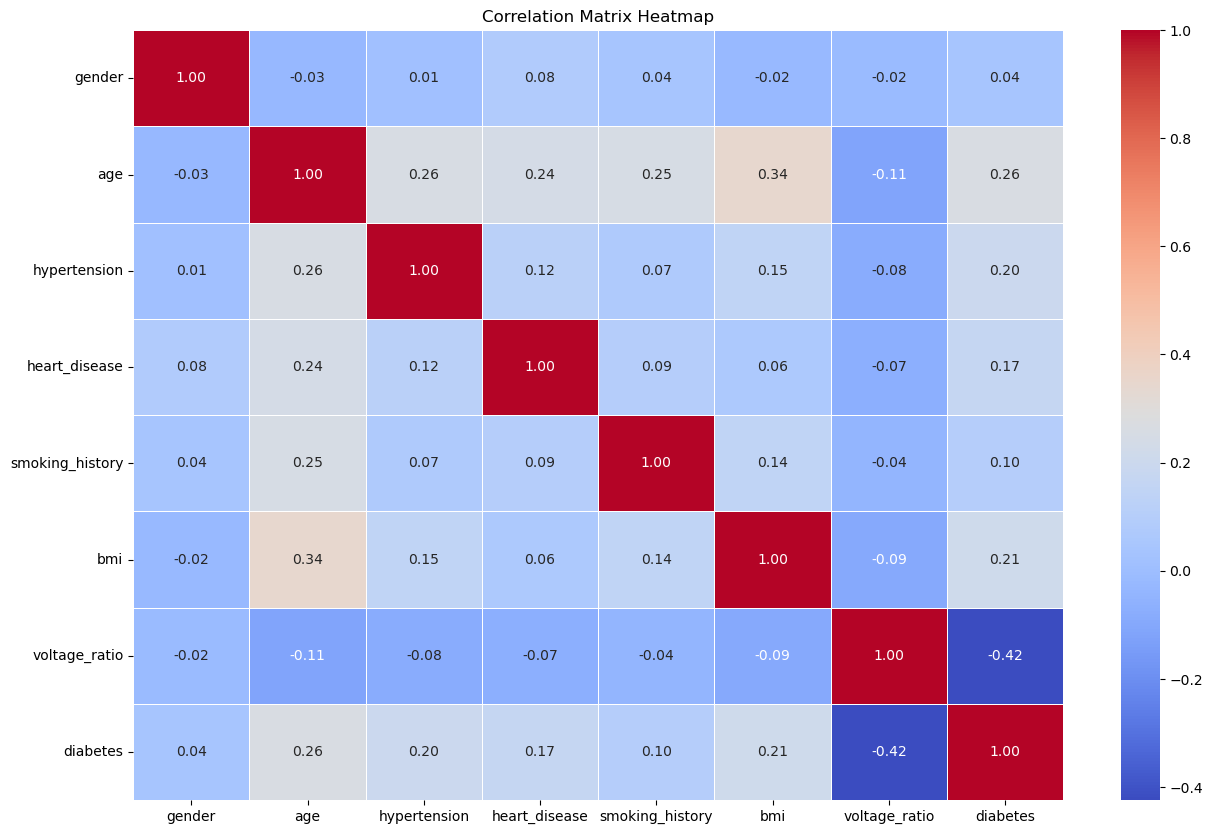

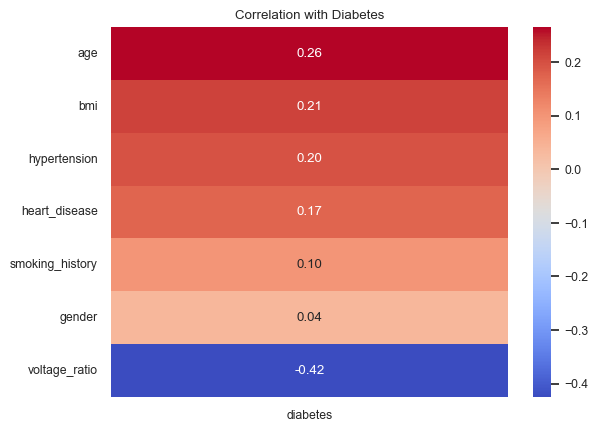

In [14]:
# Compute the correlation matrix
correlation_matrix = df.corr()
#Graph I.
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()


#Graph II
# Create a heatmap of the correlations with the target column
corr = df.corr()
target_corr = corr['diabetes'].drop('diabetes')

# Sort correlation values in descending order
target_corr_sorted = target_corr.sort_values(ascending=False)

sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Diabetes')
plt.show()

In [57]:
df_new = df.copy()

In [58]:
# Split data into features and target variable
X = df_new[['voltage_ratio', 'bmi', 'age']]
y = df_new['diabetes']


In [59]:

over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.5)

In [60]:

steps = [('o', over), ('u', under)]
pipeline = imbPipeline(steps=steps)
# transform the dataset
X, y = pipeline.fit_resample(X, y)

In [32]:
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)
standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train)
X_test= standard_scaler.transform(X_test)


In [61]:
model = RandomForestClassifier(criterion='gini',max_features='sqrt')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)
result = model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)

# Predict on the test set with the best model
y_pred = model.predict(X_test)
print('Training accuracy:', train_accuracy)
print("Model Accuracy : ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Training accuracy: 0.9762532981530343
Model Accuracy :  0.8654687202890283
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      6957
           1       0.82      0.77      0.80      3561

    accuracy                           0.87     10518
   macro avg       0.85      0.84      0.85     10518
weighted avg       0.86      0.87      0.86     10518



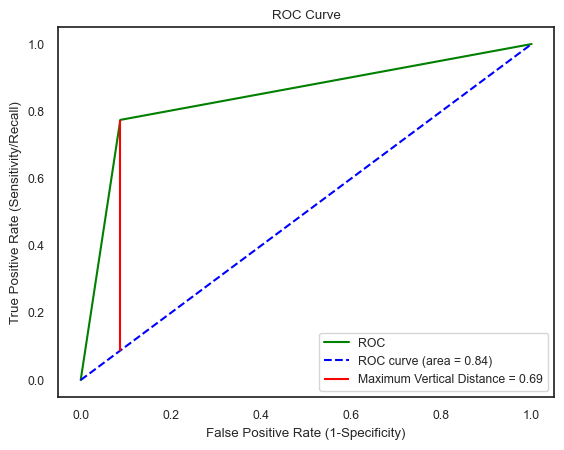

In [63]:
#PLOTTING GRAPH for model 1
#ROC curve
from sklearn.metrics import roc_auc_score,roc_curve

roc_auc_score(y_test,y_pred)
roc_curve(y_test,y_pred)
fpr,tpr,thresholds = roc_curve(y_test,y_pred)
auc = roc_auc_score(y_test,y_pred)
mvd = tpr[1]-fpr[1]
plt.plot(fpr, tpr, color='green', label='ROC')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--',label='ROC curve (area = %0.2f)' % auc)
plt.vlines(x = fpr, ymin = fpr, ymax = tpr,
           colors = 'red',
           label = 'Maximum Vertical Distance = %0.2f' % mvd)
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.title('ROC Curve')
plt.legend()
plt.show()

[0.         0.76804268 1.        ]
[0.         0.08221935 1.        ]
[2 1 0]
0.8429116686096406
Threshold value is: 1


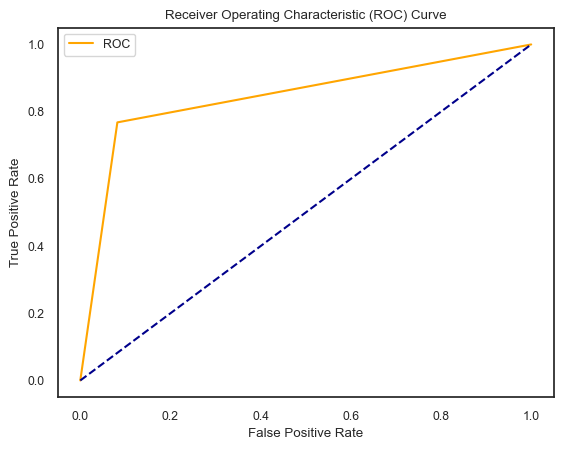

In [43]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

y_true = np.array([0,0, 1, 1,1])
y_scores = np.array([0.0,0.09, .05, .75,1])

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
print(tpr)
print(fpr)
print(thresholds)
print(roc_auc_score(y_test, y_pred))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr)

         Feature  Importance
0  voltage_ratio        0.43
1            bmi        0.30
2            age        0.27


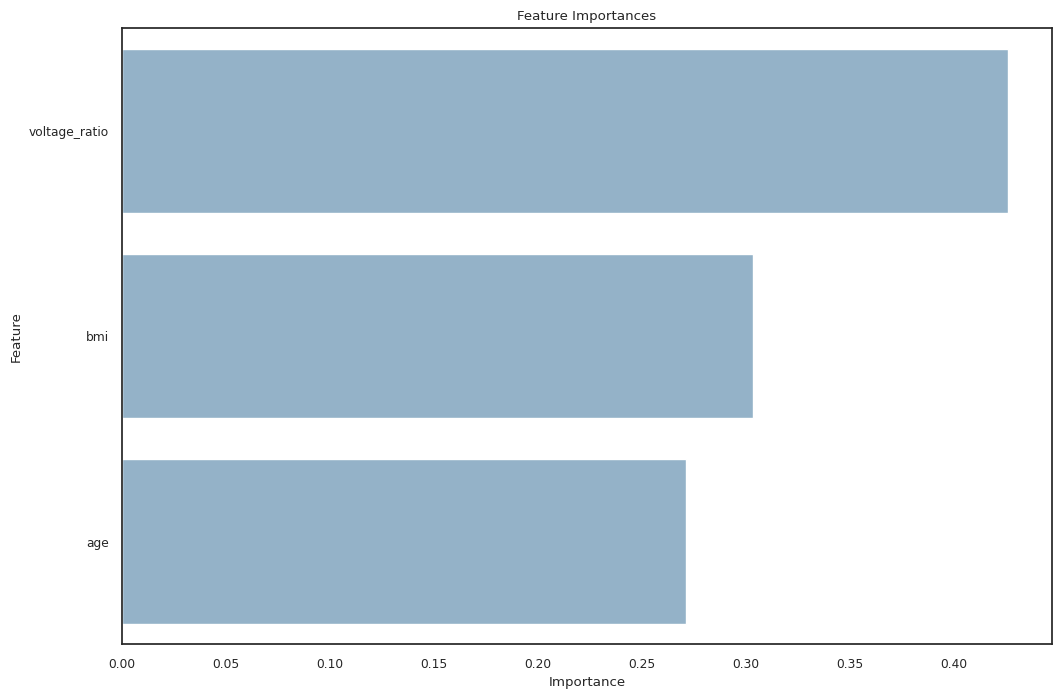

In [21]:
# Then we add the numeric feature names
feature_names = list(df_new[['voltage_ratio', 'bmi', 'age']])
# And now let's get the feature importances
importances = model.feature_importances_

# Create a dataframe for feature importance
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the dataframe by importance
importance_df = importance_df.sort_values('Importance', ascending=False)

# Print the feature importances
print(importance_df)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.show()

In [22]:
model = LogisticRegression()
result = model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)

# Predict on the test set with the best model
y_pred = model.predict(X_test)
print('Training accuracy:', train_accuracy)
print("Model Accuracy : ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Training accuracy: 0.817252608809337
Model Accuracy :  0.8168853394181403
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      6957
           1       0.77      0.65      0.71      3561

    accuracy                           0.82     10518
   macro avg       0.80      0.78      0.79     10518
weighted avg       0.81      0.82      0.81     10518



In [23]:
model = SVC()
result = model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)

# Predict on the test set with the best model
y_pred = model.predict(X_test)
print('Training accuracy:', train_accuracy)
print("Model Accuracy : ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Training accuracy: 0.8372911169744943
Model Accuracy :  0.8344742346453699
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      6957
           1       0.80      0.68      0.74      3561

    accuracy                           0.83     10518
   macro avg       0.82      0.80      0.81     10518
weighted avg       0.83      0.83      0.83     10518



In [24]:
model = LinearDiscriminantAnalysis()
result = model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)

# Predict on the test set with the best model
y_pred = model.predict(X_test)
print('Training accuracy:', train_accuracy)
print("Model Accuracy : ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Training accuracy: 0.8139722836292758
Model Accuracy :  0.8105153070926031
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      6957
           1       0.80      0.59      0.68      3561

    accuracy                           0.81     10518
   macro avg       0.81      0.76      0.77     10518
weighted avg       0.81      0.81      0.80     10518



In [25]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier()
result = model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)

# Predict on the test set with the best model
y_pred = model.predict(X_test)
print('Training accuracy:', train_accuracy)
print("Model Accuracy : ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Training accuracy: 0.838265706339585
Model Accuracy :  0.8337136337706789
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      6957
           1       0.78      0.71      0.74      3561

    accuracy                           0.83     10518
   macro avg       0.82      0.80      0.81     10518
weighted avg       0.83      0.83      0.83     10518



In [26]:
print("hello world")

hello world


n_components = np.argmax(cumulativesum >= 0.90) + 1
n_components

In [49]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df_new = df.copy()
# Split data into features and target variable
X = df_new.drop('diabetes', axis=1)
y = df_new['diabetes']# Define resampling
over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = imbPipeline(steps=steps)
# transform the dataset
X, y = pipeline.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)
standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train)
X_test= standard_scaler.transform(X_test)

pca = PCA(n_components=1)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [50]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier()
result = model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)

# Predict on the test set with the best model
y_pred = model.predict(X_test)
print('Training accuracy:', train_accuracy)
print("Model Accuracy : ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Training accuracy: 0.7783165751503482
Model Accuracy :  0.7731507891234075
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      6957
           1       0.67      0.65      0.66      3561

    accuracy                           0.77     10518
   macro avg       0.75      0.74      0.74     10518
weighted avg       0.77      0.77      0.77     10518



In [51]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df_new = df.copy()
# Split data into features and target variable
X = df_new.drop('diabetes', axis=1)
y = df_new['diabetes']# Define resampling
over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = imbPipeline(steps=steps)
# transform the dataset
X, y = pipeline.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)
standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train)
X_test= standard_scaler.transform(X_test)

pca = PCA(n_components=2)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [52]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier()
result = model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)

# Predict on the test set with the best model
y_pred = model.predict(X_test)
print('Training accuracy:', train_accuracy)
print("Model Accuracy : ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Training accuracy: 0.8027526206945732
Model Accuracy :  0.7970146415668378
              precision    recall  f1-score   support

           0       0.83      0.86      0.85      6957
           1       0.72      0.66      0.69      3561

    accuracy                           0.80     10518
   macro avg       0.77      0.76      0.77     10518
weighted avg       0.79      0.80      0.80     10518



In [53]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df_new = df.copy()
# Split data into features and target variable
X = df_new.drop('diabetes', axis=1)
y = df_new['diabetes']# Define resampling
over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = imbPipeline(steps=steps)
# transform the dataset
X, y = pipeline.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)
standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train)
X_test= standard_scaler.transform(X_test)

pca = PCA(n_components=3)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [54]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier()
result = model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)

# Predict on the test set with the best model
y_pred = model.predict(X_test)
print('Training accuracy:', train_accuracy)
print("Model Accuracy : ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Training accuracy: 0.8245263733390382
Model Accuracy :  0.8173607149648222
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      6957
           1       0.75      0.69      0.72      3561

    accuracy                           0.82     10518
   macro avg       0.80      0.79      0.79     10518
weighted avg       0.81      0.82      0.82     10518



In [55]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df_new = df.copy()
# Split data into features and target variable
X = df_new.drop('diabetes', axis=1)
y = df_new['diabetes']# Define resampling
over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = imbPipeline(steps=steps)
# transform the dataset
X, y = pipeline.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)
standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train)
X_test= standard_scaler.transform(X_test)

pca = PCA(n_components=4)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [56]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier()
result = model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)

# Predict on the test set with the best model
y_pred = model.predict(X_test)
print('Training accuracy:', train_accuracy)
print("Model Accuracy : ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Training accuracy: 0.8368870189450665
Model Accuracy :  0.8346643848640426
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      6957
           1       0.78      0.72      0.75      3561

    accuracy                           0.83     10518
   macro avg       0.82      0.81      0.81     10518
weighted avg       0.83      0.83      0.83     10518



In [57]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df_new = df.copy()
# Split data into features and target variable
X = df_new.drop('diabetes', axis=1)
y = df_new['diabetes']# Define resampling
over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = imbPipeline(steps=steps)
# transform the dataset
X, y = pipeline.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)
standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train)
X_test= standard_scaler.transform(X_test)

pca = PCA(n_components=5)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [58]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier()
result = model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)

# Predict on the test set with the best model
y_pred = model.predict(X_test)
print('Training accuracy:', train_accuracy)
print("Model Accuracy : ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Training accuracy: 0.8366017732772351
Model Accuracy :  0.8334284084426697
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      6957
           1       0.80      0.67      0.73      3561

    accuracy                           0.83     10518
   macro avg       0.82      0.79      0.81     10518
weighted avg       0.83      0.83      0.83     10518



In [59]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df_new = df.copy()
# Split data into features and target variable
X = df_new.drop('diabetes', axis=1)
y = df_new['diabetes']# Define resampling
over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = imbPipeline(steps=steps)
# transform the dataset
X, y = pipeline.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)
standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train)
X_test= standard_scaler.transform(X_test)

pca = PCA(n_components=6)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [60]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier()
result = model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)

# Predict on the test set with the best model
y_pred = model.predict(X_test)
print('Training accuracy:', train_accuracy)
print("Model Accuracy : ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Training accuracy: 0.8406665240438328
Model Accuracy :  0.8275337516638144
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      6957
           1       0.77      0.70      0.73      3561

    accuracy                           0.83     10518
   macro avg       0.81      0.80      0.80     10518
weighted avg       0.83      0.83      0.83     10518



In [61]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df_new = df.copy()
# Split data into features and target variable
X = df_new.drop('diabetes', axis=1)
y = df_new['diabetes']# Define resampling
over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = imbPipeline(steps=steps)
# transform the dataset
X, y = pipeline.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)
standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train)
X_test= standard_scaler.transform(X_test)

pca = PCA(n_components=7)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [62]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier()
result = model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)

# Predict on the test set with the best model
y_pred = model.predict(X_test)
print('Training accuracy:', train_accuracy)
print("Model Accuracy : ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Training accuracy: 0.8433288169435926
Model Accuracy :  0.8384673892374976
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      6957
           1       0.77      0.75      0.76      3561

    accuracy                           0.84     10518
   macro avg       0.82      0.82      0.82     10518
weighted avg       0.84      0.84      0.84     10518



In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn.feature_selection import mutual_info_regression


plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    explained_variance = pca.explained_variance_ratio_
    axs[0].bar(grid, explained_variance)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(explained_variance)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [17]:
from sklearn.decomposition import PCA

# Standardize
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Look at explained variance
plot_variance(pca);

In [18]:


# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,0.17,0.86,0.23,0.27,0.52,0.12,-1.26
1,-1.54,0.58,0.15,0.85,0.14,0.62,0.55
2,0.49,1.26,0.09,-0.04,0.33,0.66,-0.51
3,-0.06,0.21,-0.76,1.48,0.24,0.19,-1.08
4,0.01,-0.30,0.25,-1.61,-0.33,0.29,-0.16


In [19]:
print(X_pca)

        PC1   PC2   PC3   PC4   PC5   PC6   PC7
0      0.17  0.86  0.23  0.27  0.52  0.12 -1.26
1     -1.54  0.58  0.15  0.85  0.14  0.62  0.55
2      0.49  1.26  0.09 -0.04  0.33  0.66 -0.51
3     -0.06  0.21 -0.76  1.48  0.24  0.19 -1.08
4      0.01 -0.30  0.25 -1.61 -0.33  0.29 -0.16
...     ...   ...   ...   ...   ...   ...   ...
52582  0.39  1.16  0.39 -0.78  0.68 -0.60 -0.55
52583  1.65  1.05 -1.92  0.51 -0.18  0.70  0.89
52584  1.33  0.24  0.38 -2.92 -0.02 -0.44 -0.45
52585 -0.33 -0.32 -0.05 -0.70 -0.74  1.58  0.22
52586  1.93  1.12 -1.38 -1.29  0.50 -1.66  0.88

[52587 rows x 7 columns]


In [20]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
gender,0.00,-0.72,-0.03,-0.50,-0.40,0.24,-0.10
age,0.58,0.04,-0.03,0.06,0.08,0.06,-0.80
hypertension,0.35,-0.07,0.57,0.36,-0.56,-0.26,0.19
heart_disease,0.31,-0.48,0.30,0.15,0.67,0.17,0.28
smoking_history,0.33,-0.28,-0.73,0.28,-0.08,-0.37,0.23
bmi,0.44,0.35,-0.18,-0.08,-0.19,0.69,0.37
blood_glucose_level,0.37,0.23,0.10,-0.72,0.14,-0.48,0.20


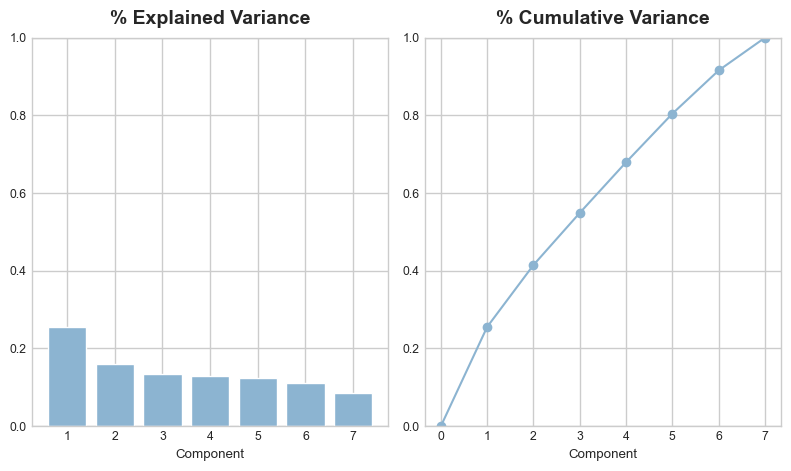

In [21]:
# Look at explained variance
plot_variance(pca);

In [117]:
mi_scores = make_mi_scores(X_pca, y, discrete_features=False)
mi_scores

PC1   0.20
PC4   0.13
PC2   0.10
PC5   0.09
PC3   0.08
PC6   0.05
PC7   0.04
Name: MI Scores, dtype: float64

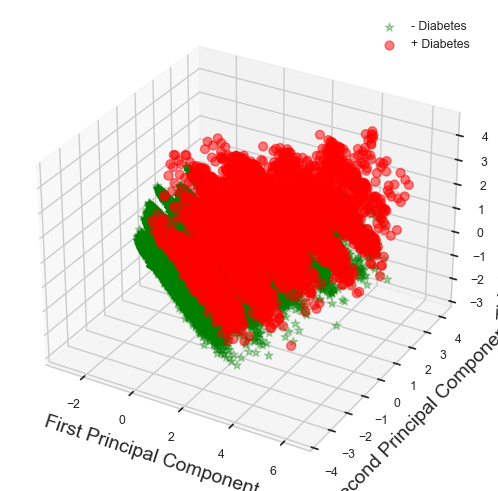

In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
# %matplotlib notebook

X = df_new.drop('diabetes', axis=1)
y = df_new['diabetes']# Define resampling
sc = StandardScaler()

scaler = StandardScaler()
scaler.fit(X) 
X_scaled = scaler.transform(X)

pca = PCA(n_components=3)
pca.fit(X_scaled) 
X_pca = pca.transform(X_scaled) 

ex_variance=np.var(X_pca,axis=0)
ex_variance_ratio = ex_variance/np.sum(ex_variance)
ex_variance_ratio


Xax = X_pca[:,0]
Yax = X_pca[:,1]
Zax = X_pca[:,2]

cdict = {0:'green',1:'red'}
labl = {0:'- Diabetes',1:'+ Diabetes'}
marker = {0:'*',1:'o'}
alpha = {0:.3, 1:.5}

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')

fig.patch.set_facecolor('white')
for l in np.unique(y):
 ix=np.where(y==l)
 ax.scatter(Xax[ix], Yax[ix], Zax[ix], c=cdict[l], s=40,
           label=labl[l], marker=marker[l], alpha=alpha[l])
# for loop ends
ax.set_xlabel("First Principal Component", fontsize=14)
ax.set_ylabel("Second Principal Component", fontsize=14)
ax.set_zlabel("Third Principal Component", fontsize=14)

ax.legend()
plt.show()

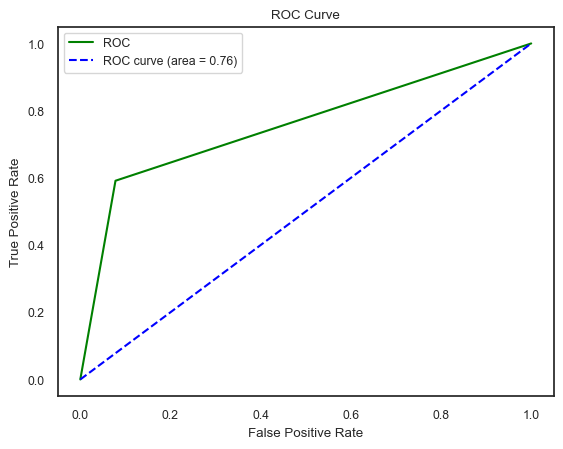

In [296]:
#PLOTTING GRAPH for model 1
#ROC curve 
roc_auc_score(y_test,y_pred)
roc_curve(y_test,y_pred)
fpr,tpr,thresholds = roc_curve(y_test,y_pred)
auc = roc_auc_score(y_test,y_pred)

plt.plot(fpr, tpr, color='green', label='ROC')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--',label='ROC curve (area = %0.2f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [93]:
pca_2 = PCA(n_components=7)
X_train_pca = pca_2.fit_transform(X_train)
X_test_pca = pca_2.transform(X_test)


pd.DataFrame(pca_2.components_, columns=(df_new.columns[:-1]), index=['component_1', 'component_2','component_3','component_4','component_5','component_6','component_7'])

,gender,age,hypertension,heart_disease,smoking_history,bmi,blood_glucose_level
component_1,-0.02,0.58,0.35,0.31,0.33,0.45,0.37
component_2,-0.72,0.04,-0.08,-0.48,-0.28,0.33,0.23
component_3,-0.09,-0.02,0.55,0.35,-0.72,-0.19,0.07
component_4,-0.43,0.06,0.42,0.01,0.32,-0.06,-0.72
component_5,-0.48,0.09,-0.53,0.66,0.03,-0.21,0.02
component_6,0.21,0.07,-0.27,0.18,-0.37,0.69,-0.49
component_7,-0.11,-0.80,0.19,0.28,0.23,0.37,0.19


In [83]:
cumulativesum = np.cumsum(pca.explained_variance_ratio_)

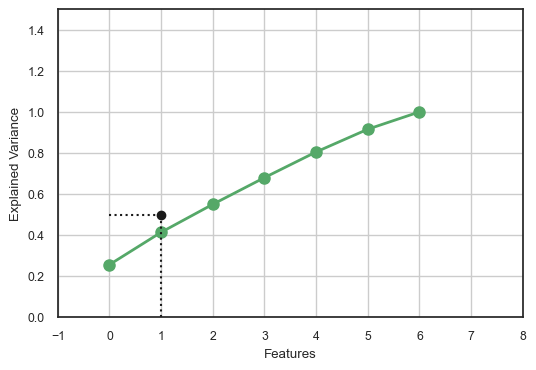

In [90]:
plt.figure(figsize=(6, 4))
plt.plot(cumulativesum, linewidth=2, color='g', marker='o', markersize=8)
plt.axis([-1, 8, 0, 1.5])
plt.xlabel("Features")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.5], 'k:')
plt.plot([0, d], [0.5, 0.5], 'k:')
plt.plot(d, 0.5, 'ko')
plt.grid(True)
plt.show();


In [ ]:
rf = RandomForestClassifier()
lr = LogisticRegression()
svm = SVC()
lda = LinearDiscriminantAnalysis()
ann = MLPClassifier()

# Split data into train and test sets
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Random Forest
rf.fit(X_train, y_train)
y_pred_train_rf = rf.predict(X_train)
train_accuracy_rf = accuracy_score(y_train, y_pred_train_rf)
y_pred_rf = rf.predict(X_test)
print('Random Forest Training accuracy:', train_accuracy)
print("Random Forest Test Accuracy : ", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

#Logistic Regression
lr.fit(X_train, y_train)
y_pred_train_lr = lr.predict(X_train)
train_accuracy_lr = accuracy_score(y_train, y_pred_train_lr)
y_pred_lr = lr.predict(X_test)
print('Logistic Regresssion Training accuracy:', train_accuracy)
print("Logistic Regression Test Accuracy : ", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

#SVM
svm.fit(X_train, y_train)
y_pred_train_svm = svm.predict(X_train)
train_accuracy_svm = accuracy_score(y_train, y_pred_train_svm)
y_pred_svm = svm.predict(X_test)
print('SVM Training accuracy:', train_accuracy)
print("SVM Test Accuracy : ", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

#Linear Discriminant Analysis
lda.fit(X_train, y_train)
y_pred_train_lda = lda.predict(X_train)
train_accuracy_lda = accuracy_score(y_train, y_pred_train_lda)
y_pred_lda = lda.predict(X_test)
print('LDA Training accuracy:', train_accuracy)
print("LDA Test Accuracy : ", accuracy_score(y_test, y_pred_lda))
print(classification_report(y_test, y_pred_lda))

#Artificial Nearest Neighbor
ann.fit(X_train, y_train)
y_pred_train_ann = ann.predict(X_train)
train_accuracy_ann = accuracy_score(y_train, y_pred_train_ann)
y_pred_ann = ann.predict(X_test)
print('ANN Training accuracy:', train_accuracy)
print("ANN Test Accuracy : ", accuracy_score(y_test, y_pred_ann))
print(classification_report(y_test, y_pred_ann))
